In [1]:
:ext NoMonomorphismRestriction FlexibleContexts FlexibleInstances UndecidableInstances
:ext MultiParamTypeClasses TypeFamilies TemplateHaskell GeneralizedNewtypeDeriving DeriveDataTypeable

In [2]:
import Data.Maybe
import Data.Typeable

import Diagrams.Prelude
import Diagrams.Backend.Cairo
import IHaskell.Display
import IHaskell.Display.Diagrams

type D = Diagram B

In [3]:
d :: D -> D
d = frame 0.5

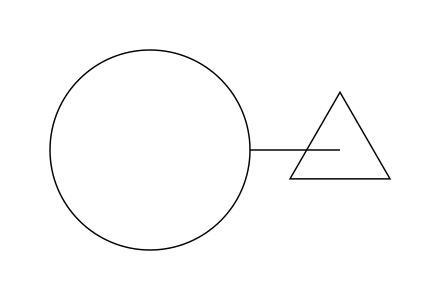

In [4]:
-- testing out juxtaposition of complex types
cr, tc :: (D, [P2 Double])
cr = (circle 1, [p2 (1, 0)])
tc = (triangle 1, [p2 (0, 0)])

d $ let (dia, pts) = hsep 0.4 [cr, tc]
    in  dia <> cubicSpline False pts

# String-drawing stuff

In [5]:
cOrtho :: V2 Double -> Trail V2 Double
cOrtho dr
  | abs dx < 0.001 || abs dy < 0.001 = fromOffsets [dr]
  | otherwise = mconcat [h, c0, v, c1, h]
  where dx :& dy = coords dr
        turnRad = min (abs dx / 5) (abs dy / 5)
        h = origin ~~ (unitX ^* (signum dx * (abs dx / 2 - turnRad)))
        v = origin ~~ (unitY ^* (signum dy * (abs dy - turnRad * 2)))
        a dir sgn = arc' turnRad dir (sgn *^ quarterTurn)
        c0 | dy > 0 = a (negated yDir) 1    | otherwise = a yDir (-1)
        c1 | dy > 0 = a (negated xDir) (-1) | otherwise = a (negated xDir) 1

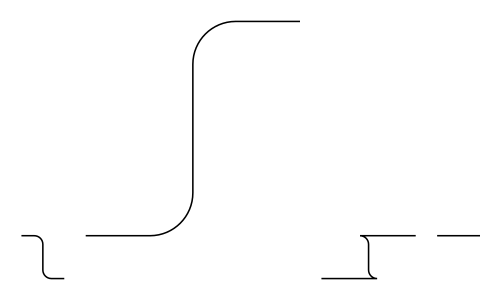

1.0

In [6]:
d . hsep 0.5 . map (stroke . cOrtho . r2) $ [(1, -1), (5, 5), (-3, -1), (1, 0)]
width . diagram $ stroke (cOrtho (r2 (1, -1)))

# General functionality

In [7]:
-- TODO: types of ins & outs, labels and directedness for strings, maybe braiding?
-- We store the positions of ports as point subdiagrams.
data PortName = In | Out deriving (Show, Eq, Ord, Typeable)
instance IsName PortName
newtype StringDiagram = SD {getSD :: D}
makeWrapped ''StringDiagram

In [8]:
showSD, examineSD :: StringDiagram -> D
showSD (SD d) = dottify red In . dottify blue Out $ d
  where dottify c n = withNameAll n (applyAll . map (atop . dot c . location))
        dot c p = circle 0.05 # lw 0 # fc c # moveTo p
examineSD = showOrigin . bg pink . showSD

showSDs, examineSDs :: [StringDiagram] -> D
showSDs = hsep 1 . map showSD
examineSDs = hsep 1 . map examineSD

instance IHaskellDisplay StringDiagram where
  display = display . frame 0.5 . showSD

In [9]:
namePoints :: IsName nm => nm -> [P2 Double] -> D -> D
namePoints nm = applyAll . map (\p -> namePoint (const p) nm)

mkSD :: [P2 Double] -> [P2 Double] -> D -> StringDiagram
mkSD iports oports = SD . frame 0.125 . alignTL . namePoints In iports . namePoints Out oports

-- Make a node out of the given D, with the given number of in and out ports, spaced evenly.
sdNode :: Int -> Int -> D -> StringDiagram
sdNode inCount outCount d = mkSD iports oports d
  where (loX, hiX) = fromMaybe (0, 0) (extentX d)
        (loY, hiY) = fromMaybe (0, 0) (extentY d)
        {- -- spaced does the right thing for n=0
        spaced x n = map (\i -> p2 (x, fromIntegral i / fromIntegral (n + 1))) [1..n]
        fit = translateY loY . scaleY (hiY - loY)
        iports = spaced loX inCount # fit
        oports = spaced hiX outCount # fit -}
        iports = map (\n -> p2 (loX, loY + 0.375 + fromIntegral n)) [0..inCount - 1]
        oports = map (\n -> p2 (hiX, loY + 0.375 + fromIntegral n)) [0..outCount - 1]

-- TODO: handle arbitrary strings (requires handling name size correctly)
boxNode :: Char -> Int -> Int -> StringDiagram
boxNode label inCount outCount = sdNode inCount outCount box
  where box = (rect 1 h <> text [label]) # fontSize (local 0.5)
        h = 0.75 + fromIntegral (max inCount outCount) - 1

In [10]:
instance Semigroup StringDiagram
instance Monoid StringDiagram where
  mempty = SD mempty
  SD d0 `mappend` SD d1 = SD (d0 === d1)

In [11]:
data Side = LeftS | RightS deriving (Show, Eq, Ord, Typeable)
instance IsName Side

-- TODO: make this more type-safe wrt matching in/out
--- Note that this is left-to-right composition, unlike (.).
sdCompose, (>>>) :: StringDiagram -> StringDiagram -> StringDiagram
sdCompose (SD d0) (SD d1) = SD $ juxt <> strings
  where combo = hsep 0.5 [LeftS .>> d0, RightS .>> d1]
        ports = [LeftS .> In, LeftS .> Out, RightS .> In, RightS .> Out]
        [newIns, midOuts, midIns, newOuts] =
          map (\k -> concat (lookup k (names combo))) ports
        juxt = combo # localize # namePoints In newIns # namePoints Out newOuts
        strings = mconcat (zipWith string midOuts midIns)
        string o i = stroke $ cOrtho (i .-. o) `at` o
(>>>) = sdCompose
infixr 5 >>>

-- Note that since diagrams form a category and not a monoid, we can't make this a true homomorphism!
sdChain :: [StringDiagram] -> StringDiagram
sdChain [] = SD mempty
sdChain sds = foldr1 sdCompose sds

# Specific components

In [12]:
pad375 :: D -> D
pad375 d = let s = strutY 0.375 in s === d === s

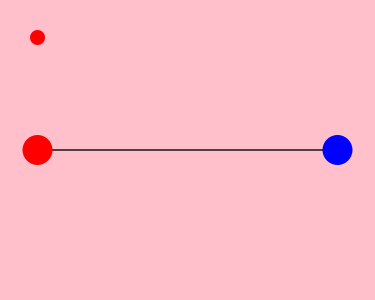

In [13]:
sdID :: StringDiagram
sdID = sdNode 1 1 . pad375 $ seg
  where seg = p2 (0, 0) ~~ p2 (1, 0)

examineSD sdID

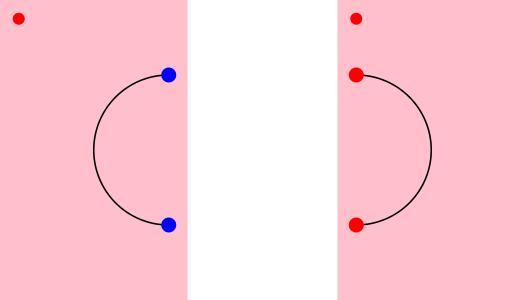

In [14]:
evRad = 0.5
estrut = strutX (1 - evRad)

ev, coev :: StringDiagram
-- TODO make this nicer
ev = sdNode 2 0 . centerX . pad375 $ arc' evRad yDir (-0.5 @@ turn) ||| estrut
coev = sdNode 0 2 . centerX . pad375 $ estrut ||| arc' evRad yDir (0.5 @@ turn)

examineSDs [coev, ev]

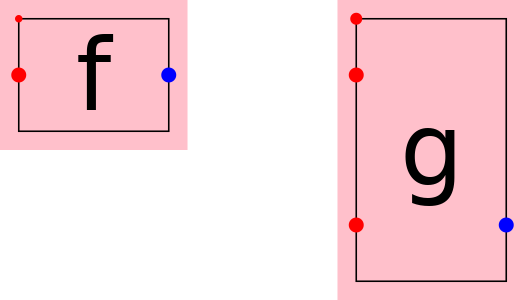

In [15]:
fn = boxNode 'f' 1 1
gn = boxNode 'g' 2 1
examineSDs [fn, gn]

# Testing

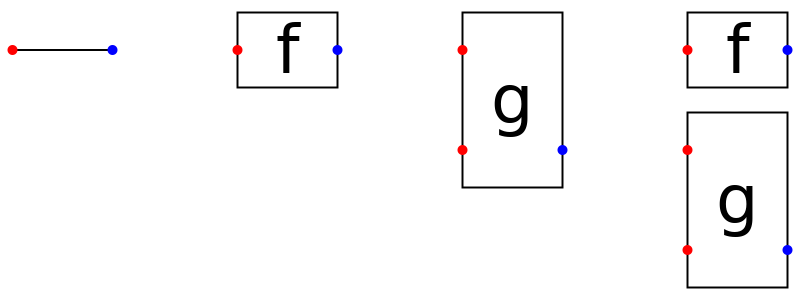

In [16]:
-- id : V → V
-- fn : V → V
-- gn : V ⊗ V → V
-- fn ⊗ gn : V ⊗ V ⊗ V → V ⊗ V
showSDs [sdID, fn, gn, fn <> gn]

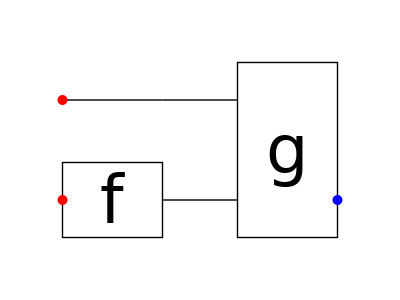

In [17]:
-- g ∘ (id ⊗ f) : V ⊗ V → V
sdID <> fn >>> gn

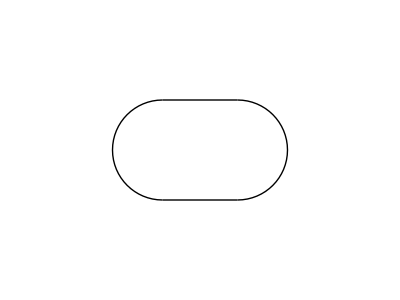

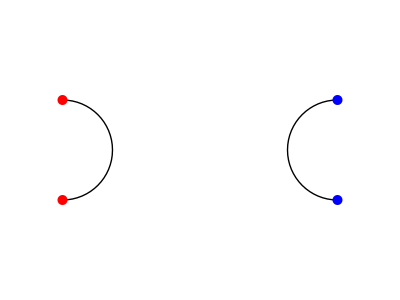

In [18]:
coev >>> ev
ev >>> coev

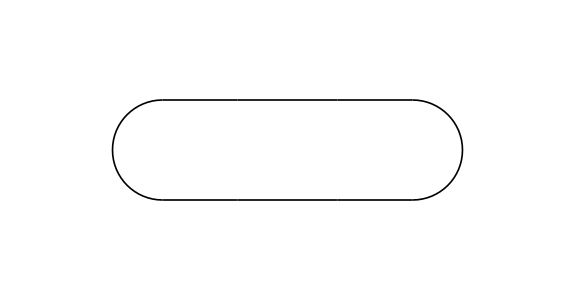

In [19]:
coev >>> sdID <> sdID >>> ev

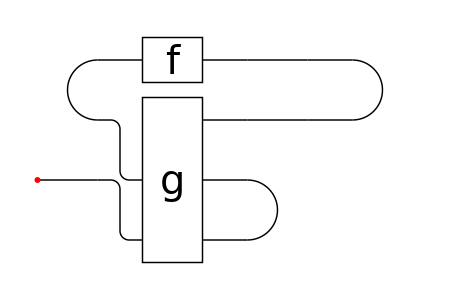

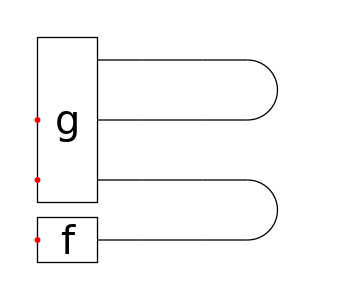

In [20]:
coev <> sdID >>> fn <> boxNode 'g' 2 3 >>> sdID <> sdID <> ev >>> ev
boxNode 'g' 2 3 <> fn >>> sdID <> sdID <> sdID <> sdID >>> ev <> ev

### Kink

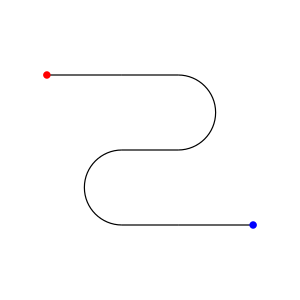

In [21]:
sdID <> coev >>> ev <> sdID

### Trace

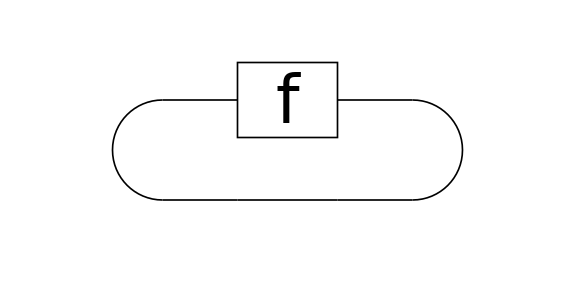

In [22]:
coev >>> fn <> sdID >>> ev

# `Tensor` integration

In [28]:
:set -i/home/benzrf/codes/haskell/Tensor

Parse error (line 1, column 1): Unknown directive: 'r'.

In [27]:
import Classes

<interactive>:1:1: error: attempting to use module ‘Classes’ (/home/benzrf/codes/haskell/Tensor/Classes.hs) which is not loaded